In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap
from explainerdashboard import ExplainerDashboard, ClassifierExplainer, InlineExplainer
import pickle
import time
import tensorflow as tf

In [3]:
class CorrOnehotEncoder:
    """
    CorrOnehotEncoder: Encodes the given column by creating one-hot encoded columns for categories that have
    a correlation higher than a threshold with the target column.
    """
    def __init__(self, column, target):
        """
        Constructor: Stores the column and target (storing the full data causes memory issues).
        
        Parameters:
            - column (pd.Series): The feature column to encode.
            - target (pd.Series): The target column.
        """
        # Force to string for groups.
        self.column = column.astype(str)
        # Convert to float32 precision to minimise memory load.
        self.target = target.astype(np.float32)

    def corr(self, x, y):
        """
        Calculate the Pearson correlation coefficient (Phi).
        
        Parameters:
            - x (tensor - float32): The first variable.
            - y (tensor - float32): The target to draw correlation to.
        
        Returns:
            - r (float32): The Pearson correlation coefficient (Phi).
        """
        mean_x = tf.reduce_mean(x)
        mean_y = tf.reduce_mean(y)
        covariance = tf.reduce_sum((x - mean_x) * (y - mean_y))
        std_x = tf.sqrt(tf.reduce_sum((x - mean_x) ** 2))
        std_y = tf.sqrt(tf.reduce_sum((y - mean_y) ** 2))
        r = covariance / (std_x * std_y)
        return r

    def encode(self, sparse_n, threshold, max_encoded):
        """
        Encode the feature column by creating one-hot encoded columns for categories that have
        a correlation higher than a threshold with the target.
        
        Parameters:
            - sparse_n (int): Minimum number of occurrences (1's) for a category in the column.
            - threshold (float): The correlation threshold.
            - max_encoded (int): The maximum number of encoded features.
        
        Returns:
            - ohe_df (pd.DataFrame): One-hot encoded columns that meet the correlation threshold.
        """
        # Convert to numpy for tensors.
        column_np = self.column.to_numpy()
        target_np = self.target.to_numpy()

        # Store results.
        ohe_list = []    
        column_names = []
        correlations = []
        # Iterate through each unique category in the column.
        for c in np.unique(column_np):
            # Convert to binary - float32 minimises memory issues.
            corr_column = (column_np == c).astype(np.float32)
            # If the category count is below sparse_n, skip encoding.
            if np.sum(corr_column) < sparse_n:
                continue
            # Convert to tensors for the correlation calculation.
            correlation = self.corr(tf.convert_to_tensor(corr_column, dtype=tf.float32), 
                                    tf.convert_to_tensor(target_np, dtype=tf.float32))
            # If the absolute correlation is greater than the threshold, add to the list.
            if abs(correlation.numpy()) > threshold:
                ohe_list.append(corr_column)
                column_names.append(c)
                # Store correlations to sort.
                correlations.append(abs(correlation.numpy()))

        # Sort the columns by their correlation with the target.
        sorted_indices = np.argsort(correlations)[::-1]
        sorted_ohe_list = []
        sorted_column_names = []
        for i in sorted_indices:
            sorted_ohe_list.append(ohe_list[i])
            sorted_column_names.append(column_names[i])

        # Limit the number of variables to max_encoded.
        if len(sorted_ohe_list) > max_encoded:
            sorted_ohe_list = sorted_ohe_list[:max_encoded]
            sorted_column_names = sorted_column_names[:max_encoded]
        # Add the encoded data to a dataframe.
        ohe_df = pd.DataFrame(np.column_stack(sorted_ohe_list), columns=sorted_column_names)
        
        if ohe_df.empty:
            print("No correlations exceed the threshold.")
            return pd.DataFrame()
        
        return ohe_df

In [4]:
# Imports the cleaned dataset.
data = pd.read_csv('Cleaned_full_data.csv')
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
# Some extra cleaning.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')
# Drop correlated features 99% +.
data = data.drop(columns=['dwin', 'dloss'])
# Normal rows with hidden strings.
data = data[~data['sport'].str.startswith(('0x', '-'), na=False)]
data = data[~data['dsport'].str.startswith(('0x', '-'), na=False)]

C:\Users\adi_s\AppData\Local\Temp\ipykernel_19568\2862124407.py:2: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.


In [ ]:
# Collect top 10. Processing time: 70 minutes.
# NOTE: Increasing sparse_n or changing precision to float16 will reduce time significantly. 
cte = CorrOnehotEncoder(data['sport'], data['label'])
ec1 = cte.encode(60, 0.001, 10)
cte = CorrOnehotEncoder(data['dsport'], data['label'])
ec2 = cte.encode(60, 0.001, 10)
cte = CorrOnehotEncoder(data['proto'], data['label'])
ec3 = cte.encode(60, 0.0, 10)
cte = CorrOnehotEncoder(data['service'], data['label'])
ec4 = cte.encode(60, 0.0, 10)
cte = CorrOnehotEncoder(data['state'], data['label'])
ec5 = cte.encode(60, 0.0, 10)
cte = CorrOnehotEncoder(data['srcip'], data['label'])
ec6 = cte.encode(60, 0.0, 10)
cte = CorrOnehotEncoder(data['dstip'], data['label'])
ec7 = cte.encode(60, 0.0, 10)

In [11]:
# Need to update this in the encoder.
for col in ec1.columns:
    ec1.rename(columns={col: 'sport_' + col}, inplace=True)
for col in ec2.columns:
    ec2.rename(columns={col: 'dsport_' + col}, inplace=True)
for col in ec3.columns:
    ec3.rename(columns={col: 'proto_' + col}, inplace=True)
for col in ec4.columns:
    ec4.rename(columns={col: 'service_' + col}, inplace=True)
for col in ec5.columns:
    ec5.rename(columns={col: 'state_' + col}, inplace=True)
for col in ec6.columns:
    ec6.rename(columns={col: 'srcip_' + col}, inplace=True)
for col in ec7.columns:
    ec7.rename(columns={col: 'dstip_' + col}, inplace=True)

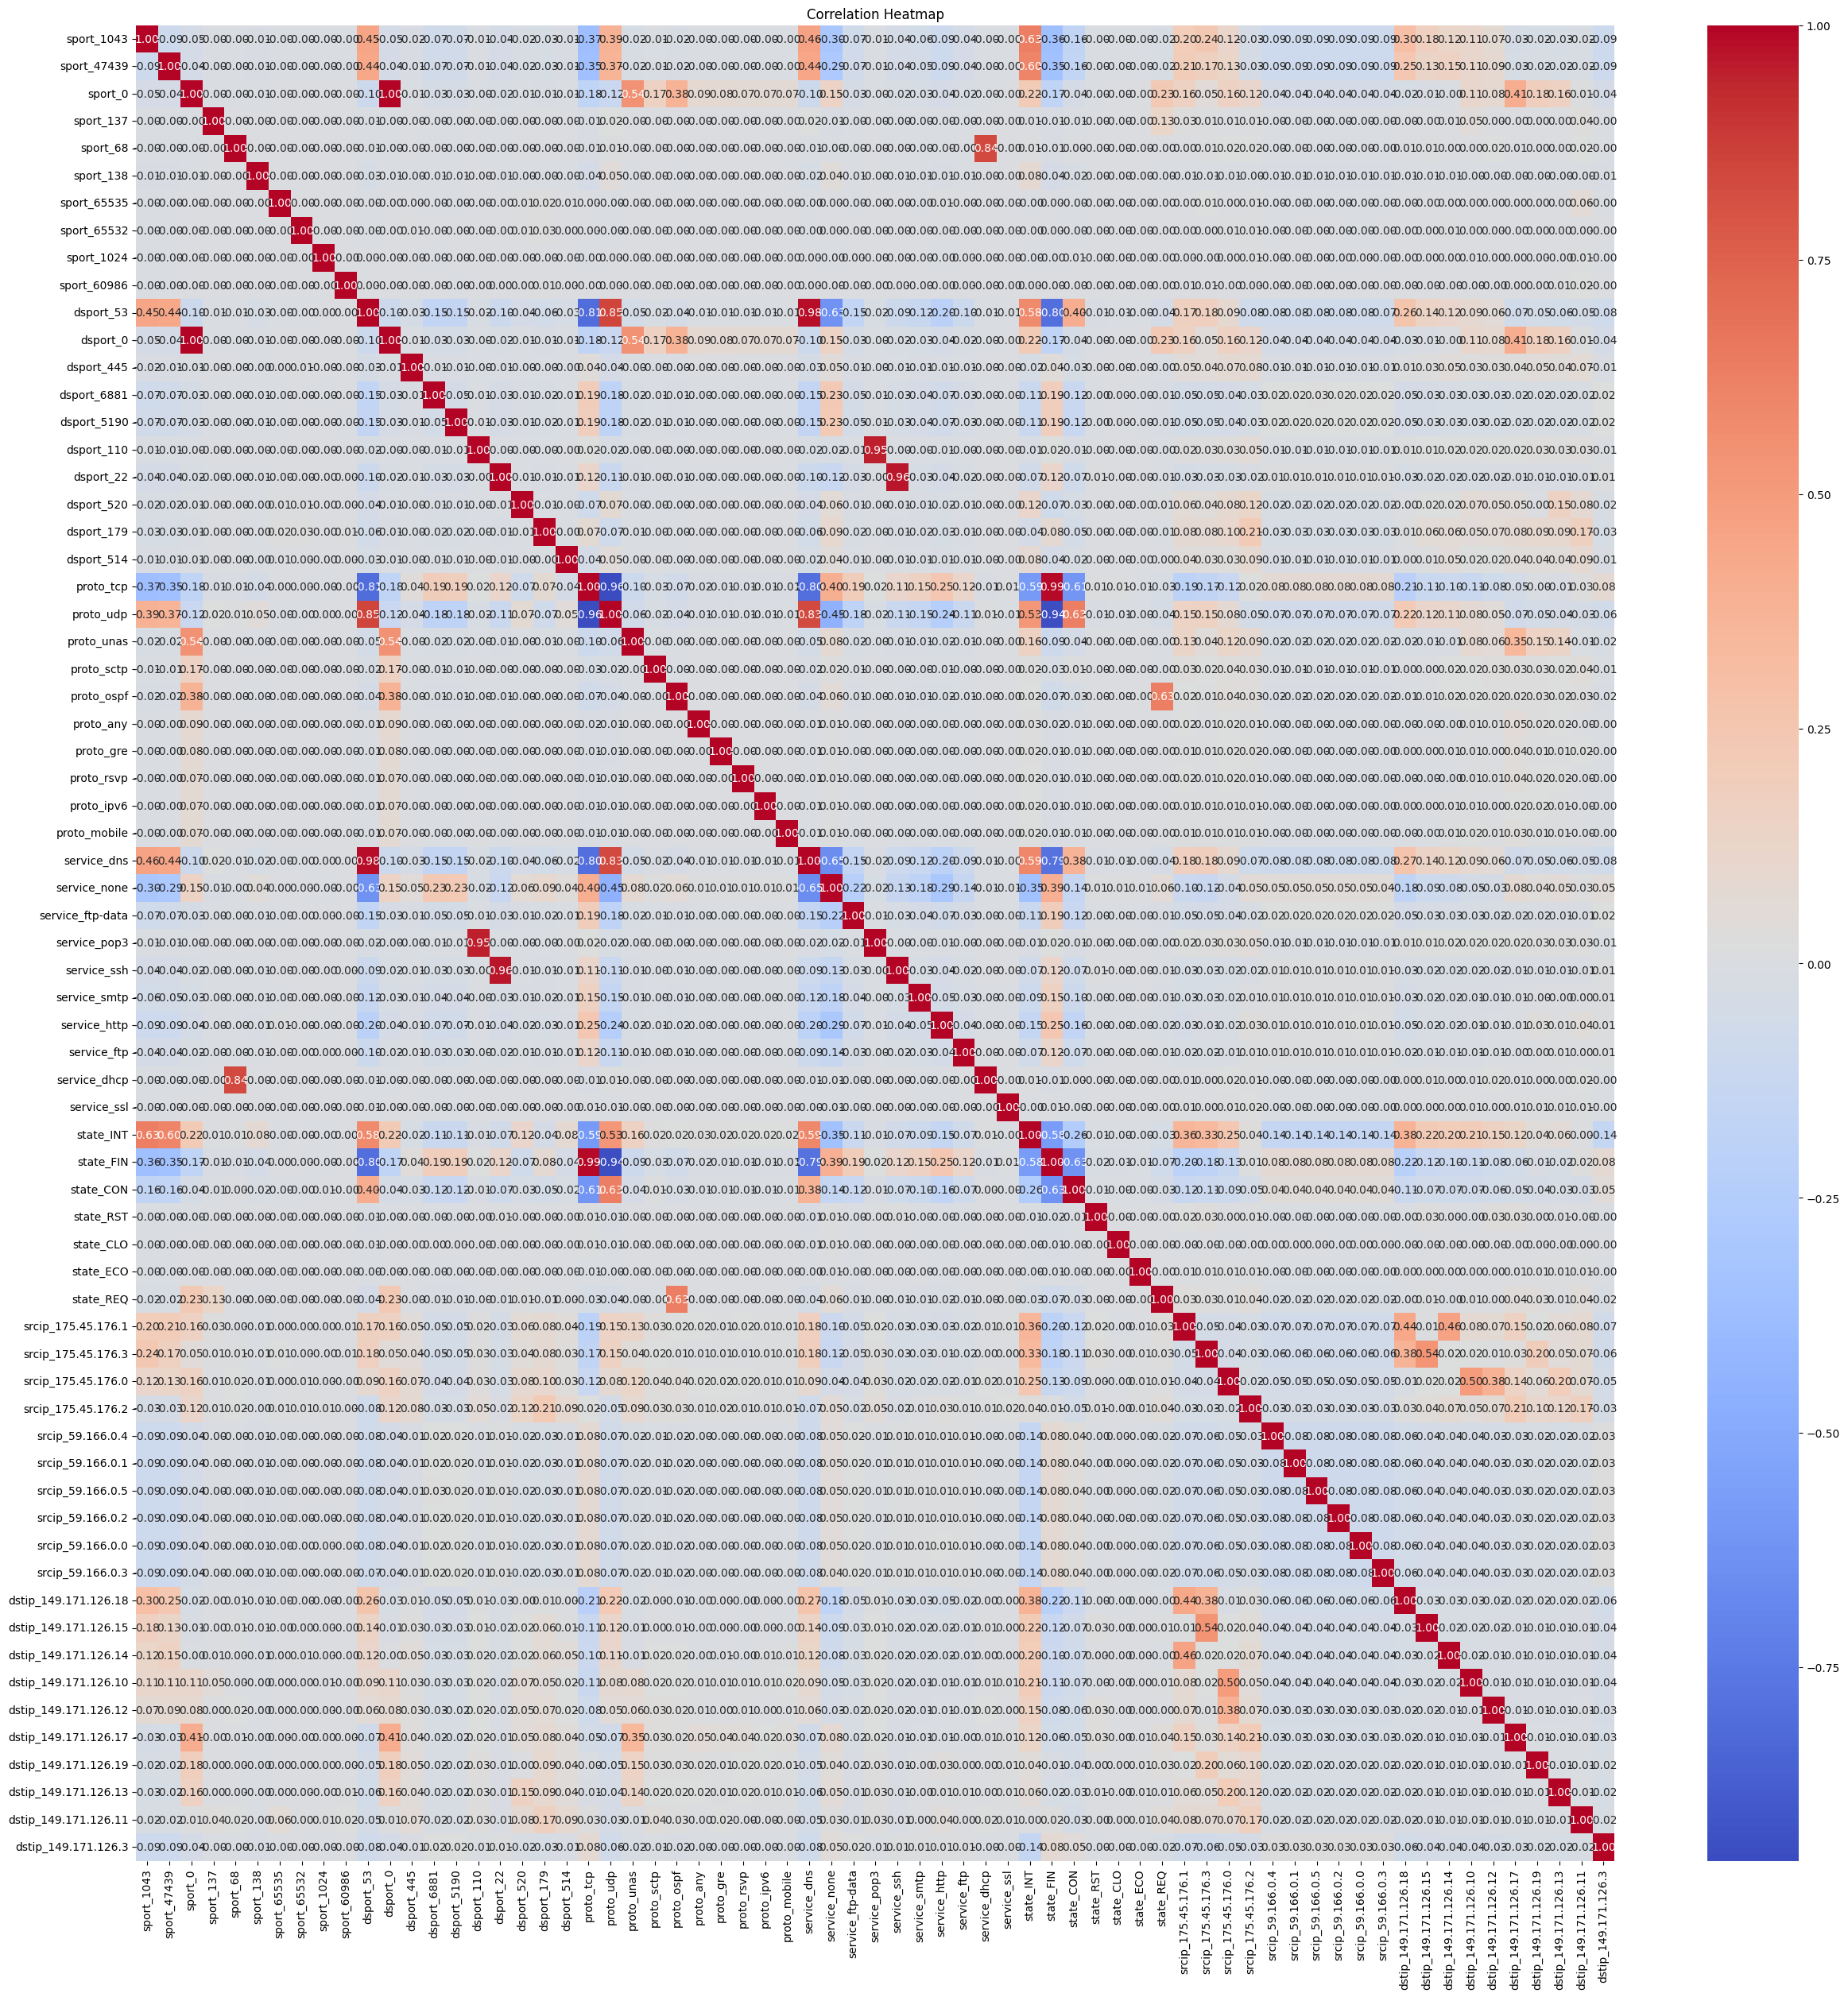

In [12]:
# Check correlation. - probably some filtering required
ohe_set = pd.concat([ec1, ec2, ec3, ec4, ec5, ec6, ec7], axis=1)
correlation_matrix = ohe_set.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
ohe_set = ohe_set.drop(columns=['dsport_0', 'state_FIN'])

In [14]:
ohe_set.to_csv('ohe_set_top10.csv')

In [10]:
# Remove IPs for now.
ohe_set = ohe_set.loc[:, ~ohe_set.columns.str.startswith(('srcip_', 'dstip_'))]

In [11]:
print(ohe_set.columns)

Index(['sport_1043', 'sport_47439', 'sport_0', 'sport_137', 'sport_68',
       'sport_138', 'sport_65535', 'sport_65532', 'sport_1024', 'sport_60986',
       'dsport_53', 'dsport_445', 'dsport_6881', 'dsport_5190', 'dsport_110',
       'dsport_22', 'dsport_520', 'dsport_179', 'dsport_514', 'proto_tcp',
       'proto_udp', 'proto_unas', 'proto_sctp', 'proto_ospf', 'proto_any',
       'proto_gre', 'proto_rsvp', 'proto_ipv6', 'proto_mobile', 'service_dns',
       'service_none', 'service_ftp-data', 'service_pop3', 'service_ssh',
       'service_smtp', 'service_http', 'service_ftp', 'service_dhcp',
       'service_ssl', 'state_INT', 'state_CON', 'state_RST', 'state_CLO',
       'state_ECO', 'state_REQ'],
      dtype='object')


In [12]:
# Essential for nominals in evaluation.
cats_dict = {}
for col in ohe_set:
    category = col.split('_')[0]
    if category not in cats_dict:
        cats_dict[category] = []
    cats_dict[category].append(col)
print(cats_dict)

{'sport': ['sport_1043', 'sport_47439', 'sport_0', 'sport_137', 'sport_68', 'sport_138', 'sport_65535', 'sport_65532', 'sport_1024', 'sport_60986'], 'dsport': ['dsport_53', 'dsport_445', 'dsport_6881', 'dsport_5190', 'dsport_110', 'dsport_22', 'dsport_520', 'dsport_179', 'dsport_514'], 'proto': ['proto_tcp', 'proto_udp', 'proto_unas', 'proto_sctp', 'proto_ospf', 'proto_any', 'proto_gre', 'proto_rsvp', 'proto_ipv6', 'proto_mobile'], 'service': ['service_dns', 'service_none', 'service_ftp-data', 'service_pop3', 'service_ssh', 'service_smtp', 'service_http', 'service_ftp', 'service_dhcp', 'service_ssl'], 'state': ['state_INT', 'state_CON', 'state_RST', 'state_CLO', 'state_ECO', 'state_REQ']}


In [13]:
# ct and other binaries might need to be filtered here too but lets just move forward into the dashboard.
# NOTE: ct could be grouped in a way as above which makes evaluation better in the dashboard.
# Not sure why there is an index error..
temp = data[['attack_cat', 'label']].reset_index(drop=True)
data = data.drop(columns=['label', 'attack_cat', 'proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(data, columns=data.columns)
scaled_data = scaled_data.reset_index(drop=True)
print(len(scaled_data))
print(len(ohe_set))
print(len(temp))
data_final = pd.concat([ohe_set, scaled_data, temp], axis=1)
print(data_final['label'].value_counts(dropna=False))

2539739
2539739
2539739
label
0    2218456
1     321283
Name: count, dtype: int64


In [14]:
X_train, X_test, y_train, y_test = train_test_split(data_final, data_final['label'], test_size=0.2, random_state=42)
# Drop attack cat before running model and store for later evaluation indexing.
# NOTE: Do we want to keep attack_cat - this means that we are training the model on data that is not expected in real-world scenario.
test_attack_cat = X_test['attack_cat']
X_train = X_train.drop(columns=['attack_cat', 'label'])
X_test = X_test.drop(columns=['attack_cat', 'label'])

In [15]:
for i in X_test:
    print(X_test[i].value_counts(dropna=False))

sport_1043
0.0    463733
1.0     44215
Name: count, dtype: int64
sport_47439
0.0    467395
1.0     40553
Name: count, dtype: int64
sport_0
0.0    497182
1.0     10766
Name: count, dtype: int64
sport_137
0.0    507873
1.0        75
Name: count, dtype: int64
sport_68
0.0    507902
1.0        46
Name: count, dtype: int64
sport_138
0.0    507266
1.0       682
Name: count, dtype: int64
sport_65535
0.0    507907
1.0        41
Name: count, dtype: int64
sport_65532
0.0    507932
1.0        16
Name: count, dtype: int64
sport_1024
0.0    507929
1.0        19
Name: count, dtype: int64
sport_60986
0.0    507936
1.0        12
Name: count, dtype: int64
dsport_53
0.0    347961
1.0    159987
Name: count, dtype: int64
dsport_445
0.0    506671
1.0      1277
Name: count, dtype: int64
dsport_6881
0.0    483024
1.0     24924
Name: count, dtype: int64
dsport_5190
0.0    483998
1.0     23950
Name: count, dtype: int64
dsport_110
0.0    507606
1.0       342
Name: count, dtype: int64
dsport_22
0.0    497770
1.0

In [16]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    443824
           1       0.99      0.98      0.98     64124

    accuracy                           1.00    507948
   macro avg       0.99      0.99      0.99    507948
weighted avg       1.00      1.00      1.00    507948

[[442911    913]
 [  1243  62881]]


In [17]:
# Reduce estimators for test purposes.
rf2 = RandomForestClassifier(random_state=42, n_estimators=10)
rf2.fit(X_train, y_train)
y_pred = rf2.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    443824
           1       0.99      0.98      0.98     64124

    accuracy                           1.00    507948
   macro avg       0.99      0.99      0.99    507948
weighted avg       1.00      1.00      1.00    507948

[[442956    868]
 [  1505  62619]]


In [24]:
X_test2 = X_test.copy()
X_test2['y_pred'] = y_pred
print(X_test2.head())
X_test_sample = X_test2.sample(n=1000)

         sport_1043  sport_47439  sport_0  sport_137  sport_68  sport_138  \
1410675         0.0          0.0      0.0        0.0       0.0        0.0   
721962          0.0          0.0      0.0        0.0       0.0        0.0   
1061152         0.0          0.0      0.0        0.0       0.0        0.0   
1461660         0.0          0.0      0.0        0.0       0.0        0.0   
1012870         0.0          0.0      0.0        0.0       0.0        0.0   

         sport_65535  sport_65532  sport_1024  sport_60986  ...  is_ftp_login  \
1410675          0.0          0.0         0.0          0.0  ...           0.0   
721962           0.0          0.0         0.0          0.0  ...           0.0   
1061152          0.0          0.0         0.0          0.0  ...           0.0   
1461660          0.0          0.0         0.0          0.0  ...           0.0   
1012870          0.0          0.0         0.0          0.0  ...           0.0   

         ct_ftp_cmd  ct_srv_src  ct_srv_dst  ct_ds

In [25]:
y_pred_final = X_test_sample['y_pred']
X_test_sample = X_test_sample.drop(columns=['y_pred'])
for i in X_test_sample:
    print(X_test_sample[i].value_counts(dropna=False))

sport_1043
0.0    897
1.0    103
Name: count, dtype: int64
sport_47439
0.0    929
1.0     71
Name: count, dtype: int64
sport_0
0.0    982
1.0     18
Name: count, dtype: int64
sport_137
0.0    1000
Name: count, dtype: int64
sport_68
0.0    1000
Name: count, dtype: int64
sport_138
0.0    999
1.0      1
Name: count, dtype: int64
sport_65535
0.0    1000
Name: count, dtype: int64
sport_65532
0.0    1000
Name: count, dtype: int64
sport_1024
0.0    1000
Name: count, dtype: int64
sport_60986
0.0    1000
Name: count, dtype: int64
dsport_53
0.0    683
1.0    317
Name: count, dtype: int64
dsport_445
0.0    998
1.0      2
Name: count, dtype: int64
dsport_6881
0.0    935
1.0     65
Name: count, dtype: int64
dsport_5190
0.0    959
1.0     41
Name: count, dtype: int64
dsport_110
0.0    999
1.0      1
Name: count, dtype: int64
dsport_22
0.0    985
1.0     15
Name: count, dtype: int64
dsport_520
0.0    996
1.0      4
Name: count, dtype: int64
dsport_179
0.0    995
1.0      5
Name: count, dtype: int64
d

In [26]:
# Nominals must be labelled with cat regardless if it is one variable or one-hot encoded. This increases processing time alot.
explainer = ClassifierExplainer(rf2, X_test, y_pred, cats=cats_dict, precision='float16')

Detected RandomForestClassifier model: Changing class type to RandomForestClassifierExplainer...
Note: model_output=='probability', so assuming that raw shap output of RandomForestClassifier is in probability space...
Generating self.shap_explainer = shap.TreeExplainer(model)


In [ ]:
ExplainerDashboard(explainer, mode='inline').run()

Building ExplainerDashboard..
Generating layout...
Calculating shap values...


c:\Users\adi_s\anaconda3\envs\conda12\Lib\site-packages\dash\dash.py:579: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.

